In [1]:
#from rdkit import Chem
import pkasolver as ps
from pkasolver import util
from pkasolver import analysis
import pandas as pd
import numpy as np

In [2]:
data_folder_Bal = "../data/Baltruschat/"


SDFfile1 = data_folder_Bal + "combined_training_datasets_unique.sdf"
SDFfile2 = data_folder_Bal + "novartis_cleaned_mono_unique_notraindata.sdf"
SDFfile3 = data_folder_Bal + "AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf"

,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,smiles,protonated,deprotonated,ka
0,6.21,6.09,10,basic,['chembl25'],1702768,Brc1c(NC2CC2)nc(C2CC2)nc1N1CCCCCC1,,,6.165950e-07
1,7.46,8.2,9,basic,['chembl25'],273537,Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1,,,3.467369e-08
2,4.2,3.94,9,basic,['datawarrior'],7175,Brc1cc2cccnc2c2ncccc12,,,6.309573e-05
3,3.73,5.91,8,acidic,['datawarrior'],998,Brc1ccc(-c2nn[n-]n2)cc1,,,1.862087e-04
4,11.0,8.94,13,basic,['chembl25'],560562,Brc1ccc(Br)c(N(CC2CC2)C2=[NH+]CCN2)c1,,,1.000000e-11

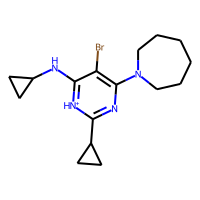
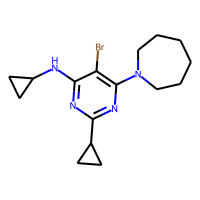
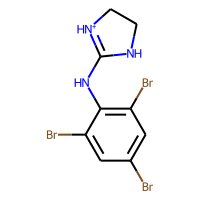
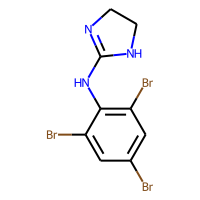
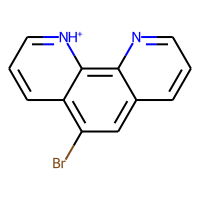
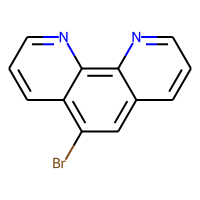
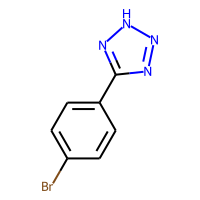
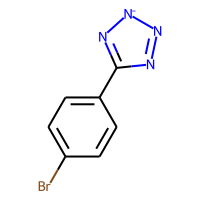
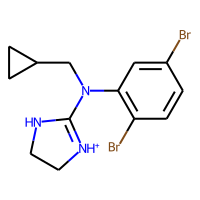
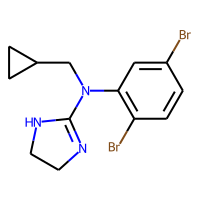

In [3]:
df1 = ps.util.import_sdf(SDFfile1)
df2 = ps.util.import_sdf(SDFfile2)
df3 = ps.util.import_sdf(SDFfile3)

#Data corrections:
df1.marvin_atom[90] = "3"


df1 = util.conjugates_to_DataFrame(df1)
df1 = util.sort_conjugates(df1)
df1 = util.pka_to_ka(df1)
df1.head()

In [4]:
dataset = []
for i in range(len(df1.index)):
    dataset.append(util.mol_to_pyg(df1.protonated[i],df1.deprotonated[i]))
    dataset[i].y = df1.ka[i]

In [5]:
dataset[0]


Data(edge_attr=[96], edge_index=[2, 96], x=[42, 7], y=6.165950018614822e-07)

In [6]:
import random

random.shuffle(dataset)

length=4795
train_dataset = dataset[:length]
test_dataset = dataset[length:]

In [7]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
Batch(batch=[1124], edge_attr=[2392], edge_index=[2, 2392], x=[1124, 7], y=[32])

Step 2:
Number of graphs in the current batch: 32
Batch(batch=[1110], edge_attr=[2312], edge_index=[2, 2312], x=[1110, 7], y=[32])

Step 3:
Number of graphs in the current batch: 32
Batch(batch=[1054], edge_attr=[2248], edge_index=[2, 2248], x=[1054, 7], y=[32])

Step 4:
Number of graphs in the current batch: 32
Batch(batch=[1058], edge_attr=[2216], edge_index=[2, 2216], x=[1058, 7], y=[32])

Step 5:
Number of graphs in the current batch: 32
Batch(batch=[940], edge_attr=[1940], edge_index=[2, 1940], x=[940, 7], y=[32])

Step 6:
Number of graphs in the current batch: 32
Batch(batch=[1162], edge_attr=[2508], edge_index=[2, 2508], x=[1162, 7], y=[32])

Step 7:
Number of graphs in the current batch: 32
Batch(batch=[1186], edge_attr=[2556], edge_index=[2, 2556], x=[1186, 7], y=[32])

Step 8:
Number of graphs in the current batch: 32
Batch(batch=[1080], edge_att

In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset[0].num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')